In [10]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')
%matplotlib inline
from IPython.display import display

from tyssue import config
from tyssue import Sheet, SheetGeometry as geom
from tyssue.dynamics import SheetModel as model

from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.plt_draw import quick_edge_draw, plot_forces
from tyssue.draw.threejs_draw import view_3js

from tyssue.io import hdf5

from tyssue.core.objects import get_opposite
from tyssue.core.generation import create_anchors

from tyssue.topology.sheet_topology import cell_division, type1_transition

import warnings
import logging
log = logging.getLogger('nb')



In [11]:
def resolve_t1s(sheet, geom, solver, max_iter=60):

    l_th = sheet.settings['threshold_length']
    i = 0
    while sheet.edge_df.length.min() < l_th:

        for edge in sheet.edge_df[sheet.edge_df.length < l_th].sort_values('length').index:
            try:
                type1_transition(sheet, edge)
            except IndexError:
                continue
            log.info('transition # {} on edge {}'.format(i+1, edge))
            sheet.reset_index()
            sheet.reset_topo()
            geom.update_all(sheet)
        solver.find_energy_min(sheet, geom, model)
        i += 1
        if i > max_iter:
            warnings.warn('Max iter reached!')
            break
    
    
    

In [56]:
h5store = '../data/hf5/fullerene.hf5'

datasets = hdf5.load_datasets(h5store,
                              data_names=['face',
                                          'vert',
                                          'edge'])

specs = config.geometry.spherical_sheet()
sheet = Sheet('emin', datasets, specs)
geom.center(sheet)

geom.update_all(sheet)
sheet.vert_df.is_active = 1

sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)

nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimentionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)
isotropic_relax(sheet, nondim_specs)
sheet.settings['threshold_length'] = 1e-2
geom.update_all(sheet)

In [57]:
sheet.Nf, sheet.Ne, sheet.Nv

(32, 180, 60)

In [61]:
res = solver.find_energy_min(sheet, geom, model)


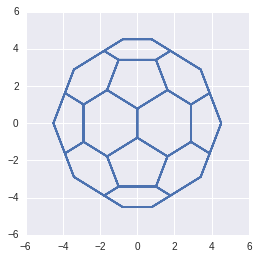

In [39]:
fig, ax = quick_edge_draw(sheet, ['z', 'x'])

### Single cell division:

```python
mother = 16

cell_division(sheet, 16, geom, angle=0)
geom.center(sheet)

res = solver.find_energy_min(sheet, geom, model)
print(res['success'])

fig, ax = quick_edge_draw(sheet, ['z', 'x'])
```

In [41]:
renderer, line = view_3js(sheet)
display(renderer)

In [62]:
ngen = 3
for n in range(ngen):
    live_cells = np.array(sheet.face_df[sheet.face_df.is_alive==1].index)
    np.random.shuffle(live_cells)
    print('Generation {}: {} cells to devide'
         .format(n, len(live_cells)))
    for cell in live_cells:
        daughter = cell_division(sheet, cell, geom, angle=np.pi * n/ngen)
        if daughter is None:
            continue
    isotropic_relax(sheet, nondim_specs)
    res = solver.find_energy_min(sheet, geom, model)
    resolve_t1s(sheet, geom, solver, max_iter=60)
    

Generation 0: 32 cells to devide
Generation 1: 64 cells to devide
Generation 2: 128 cells to devide


In [51]:
res = solver.find_energy_min(sheet, geom, model)


In [105]:
m = np.arange(9).reshape((3, 3))

In [106]:
m

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [107]:
m.flatten()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [140]:
up_pos = (sheet.upcast_srce(sheet.vert_df[sheet.coords]) - 
          sheet.upcast_face(sheet.face_df[sheet.coords]).values)
up_pos['face'] = sheet.edge_df['face']

def _svd(df):
    u, s, v = np.linalg.svd(df[['x', 'y', 'z']],
                            full_matrices=False)
    cols = ['sx', 'sy', 'sz',
            'v_xx', 'v_xy', 'v_xz',
            'v_yx', 'v_yy', 'v_yz',
            'v_zx', 'v_zy', 'v_zz',]
    
    data = pd.Series(np.hstack((s, v.ravel())),
                     index=cols)
    return data

usv = up_pos.groupby('face').apply(_svd)


def rot(df, vs):
    r_mat = vs.loc[df['face'].iloc[0],
                   ['v_xx', 'v_xy', 'v_xz',
                    'v_yx', 'v_yy', 'v_yz',
                    'v_zx', 'v_zy', 'v_zz',]].values.T.reshape((3, 3))
    
    rotated = df[list('xyz')].copy()
    
    rotated[list('xyz')] = np.dot(df[list('xyz')], r_mat)
    return rotated


In [142]:
rotated = up_pos.groupby('face').apply(rot, usv)

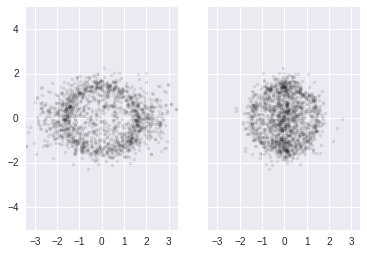

In [146]:
fig, axes = plt.subplots(1, 2, sharey=True)


for f, pos in rotated.groupby(level='face'):
    axes[0].plot(pos.x, pos.y, 'k.', alpha=0.1)
    axes[1].plot(pos.z, pos.y, 'k.', alpha=0.1)

for ax in axes:
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect("equal")

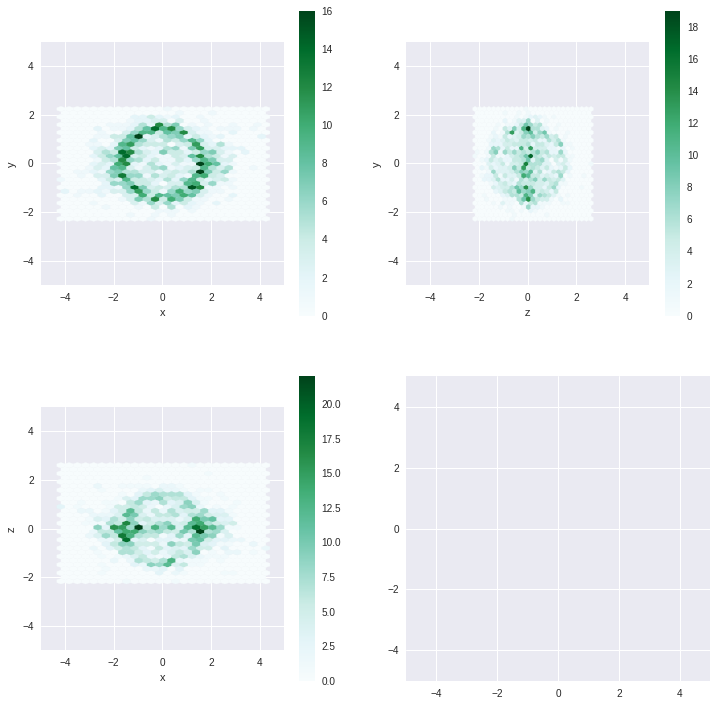

In [157]:
fig, axes = plt.subplots(2, 2)

rotated.plot.hexbin(x='x', y='y',
                    gridsize=25, ax=axes[0][0])

rotated.plot.hexbin(x='x', y='z',
                    gridsize=25, ax=axes[1][0])

rotated.plot.hexbin(x='z', y='y',
                    gridsize=25, ax=axes[0][1])

for ax in axes.ravel():
    ax.set_aspect("equal")
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))

fig.set_size_inches(12, 12)

In [89]:
up_pos[up_pos['face'] == 0][sheet.coords].mean()

x   -9.914304
y   -2.186334
z   -4.641232
dtype: float64

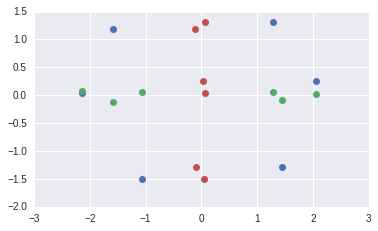

In [95]:
rot = np.dot(up_pos[up_pos['face'] == 0][sheet.coords], V.T)
fig, ax = plt.subplots()
ax.plot(rot[:, 0], rot[:, 1], 'o')
ax.plot(rot[:, 0], rot[:, 2], 'o')
ax.plot(rot[:, 2], rot[:, 1], 'o')

ax.set_aspect('equal')

In [63]:
renderer, line = view_3js(sheet)
display(renderer)

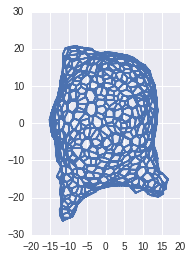

In [83]:
fig, ax = quick_edge_draw(sheet, ['z', 'x'])

In [20]:
res = solver.find_energy_min(sheet, geom, model)

In [85]:
renderer, line = view_3js(sheet)
display(renderer)

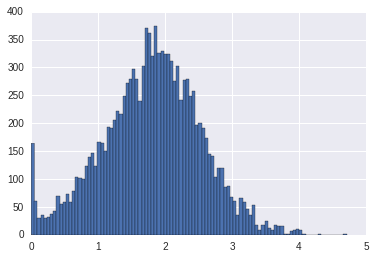

In [21]:
fig, ax = plt.subplots()

h= ax.hist(sheet.edge_df.length, bins=100)

In [22]:
from tyssue.io import hdf5

In [17]:
sheet.Nf, sheet.Ne, sheet.Nv

(128, 756, 252)

In [23]:
from tyssue.core.generation import extrude

organo_datasets = extrude(sheet.datasets, scale=0.9)



from tyssue import Monolayer, MonoLayerGeometry
from tyssue.config.geometry import bulk_spec

organo = Monolayer('colo', organo_datasets, bulk_spec())
renderer, line = view_3js(organo)
display(renderer)

In [24]:
ls ../data


blend/  csv/  gif/  hf5/  obj/  png/  polyhedra/  svg/


In [26]:
hdf5.save_datasets('../data/hf5/organo.hf5', organo)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['contractility', 'vol_elasticity', 'prefered_height', 'prefered_area', 'prefered_vol', 'height', 'rho', 'vol', 'basal_shift', 'segment']]

  exec(code_obj, self.user_global_ns, self.user_ns)
/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['letter', 'segment']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
organo.data_names

['face', 'cell', 'edge', 'vert']

In [89]:
to_rm_faces = organo.face_df['x'] < 0

to_rm_edges = organo.upcast_face(to_rm_faces)
organo.remove(to_rm_edges)
organo.reset_index()
organo.reset_topo()


In [90]:
renderer, line = view_3js(organo)
display(renderer)


In [91]:
from tyssue.io import obj

In [92]:
basal = organo.get_sub_sheet('basal')
apical = organo.get_sub_sheet('apical')
lateral = organo.get_sub_sheet('sagital')


In [48]:
renderer, line = view_3js(basal)
display(renderer)


In [93]:
obj.save_junction_mesh('../data/obj/half_organo.obj', organo)

obj.save_junction_mesh('../data/obj/half_organo_basal.obj', basal)
obj.save_junction_mesh('../data/obj/half_organo_apical.obj', apical)
obj.save_junction_mesh('../data/obj/half_organo_lateral.obj', lateral)



                be advised the file cannot be read back in vispy
